In [1]:
import re
import nltk
import tweepy
import numpy as np
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import csv
import string

from nltk.corpus import stopwords

import gensim
from matplotlib import pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
data18 = pd.read_csv("2018.csv")
data19 = pd.read_csv("2019.csv")
data20 = pd.read_csv("2020.csv")
data21 = pd.read_csv("2021.csv")

In [3]:
data = pd.concat([data18, data19,data20, data21])

In [4]:
data.head(5)

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,reply_to,retweet_date,translate,trans_src,trans_dest,time,mentions,replies_count,retweets_count,likes_count
0,0.0,1079469237230493696,1079155749077475328,1546200496000.0,2018-12-30 20:08:16,0,NaN,@Ben757677 @vincent13031925 Thanks Tesla owner...,en,[],...,"[{'screen_name': 'vincent13031925', 'name': 'V...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1079459047252709377,1079457030060924928,1546198066000.0,2018-12-30 19:27:46,0,NaN,"@Grimezsz Turns out if you take Dayquil, you e...",en,[],...,"[{'screen_name': 'Grimezsz', 'name': '☾laire d...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1078716366591483904,1078716366591483904,1546020998000.0,2018-12-28 18:16:38,0,NaN,Excited to have Larry Ellison &amp; Kathleen W...,en,[],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1078529476018008064,1078529330492321793,1545976439000.0,2018-12-28 05:53:59,0,NaN,@NutmegTheRed @Tesla Ok,und,[],...,"[{'screen_name': 'Tesla', 'name': 'Tesla', 'id...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1078395092090699776,1078383289356902401,1545944400000.0,2018-12-27 21:00:00,0,NaN,@westcoastbill Tesla team did a great job!,en,[],...,"[{'screen_name': 'westcoastbill', 'name': 'bil...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#noticed there was some data points from before the desired date, here i am dropping those datapoints
data = data[~(data['date'] < '2018-01-01')]

In [6]:
data.shape

(19095, 44)

In [7]:
data.isna().sum()

Unnamed: 0          3115
id                     0
conversation_id        0
created_at             0
date                   0
timezone               0
place              19095
tweet                  0
language               0
hashtags               0
cashtags               0
user_id                0
user_id_str         3115
username               0
name                   0
day                 3115
hour                3115
link                   0
urls                   0
photos                 0
video                  0
thumbnail          17911
retweet                0
nlikes              3115
nreplies            3115
nretweets           3115
quote_url          18430
search              3115
near               19095
geo                19095
source             19095
user_rt_id         19095
user_rt            19095
retweet_id         19095
reply_to               0
retweet_date       19095
translate          19095
trans_src          19095
trans_dest         19095
time               15980


In [8]:
data.columns

Index(['Unnamed: 0', 'id', 'conversation_id', 'created_at', 'date', 'timezone',
       'place', 'tweet', 'language', 'hashtags', 'cashtags', 'user_id',
       'user_id_str', 'username', 'name', 'day', 'hour', 'link', 'urls',
       'photos', 'video', 'thumbnail', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'quote_url', 'search', 'near', 'geo', 'source',
       'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
       'translate', 'trans_src', 'trans_dest', 'time', 'mentions',
       'replies_count', 'retweets_count', 'likes_count'],
      dtype='object')

In [9]:
data["tweet"]

0       @Ben757677 @vincent13031925 Thanks Tesla owner...
1       @Grimezsz Turns out if you take Dayquil, you e...
2       Excited to have Larry Ellison &amp; Kathleen W...
3                                 @NutmegTheRed @Tesla Ok
4              @westcoastbill Tesla team did a great job!
                              ...                        
3110    @flcnhvy Tesla is responsible for 2/3 of all t...
3111    So proud of the Tesla team for achieving this ...
3112    @newscientist Um, we have giant fusion reactor...
3113    @comma_ai Tesla Full Self-Driving will work at...
3114    @PPathole Dojo isn’t needed, but will make sel...
Name: tweet, Length: 19095, dtype: object

In [10]:
data["created_at"]

0                                 1546200496000.0
1                                 1546198066000.0
2                                 1546020998000.0
3                                 1545976439000.0
4                                 1545944400000.0
                          ...                    
3110    2021-01-02 18:59:09 Arabian Standard Time
3111    2021-01-02 18:51:49 Arabian Standard Time
3112    2021-01-02 16:23:28 Arabian Standard Time
3113    2021-01-02 07:20:48 Arabian Standard Time
3114    2021-01-01 04:58:30 Arabian Standard Time
Name: created_at, Length: 19095, dtype: object

In [11]:
data["date"]

0       2018-12-30 20:08:16
1       2018-12-30 19:27:46
2       2018-12-28 18:16:38
3       2018-12-28 05:53:59
4       2018-12-27 21:00:00
               ...         
3110             2021-01-02
3111             2021-01-02
3112             2021-01-02
3113             2021-01-02
3114             2021-01-01
Name: date, Length: 19095, dtype: object

In [12]:
pd.set_option("display.max_colwidth", -1)
data.head(5)

<ipython-input-12-a5766f8aca63>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,reply_to,retweet_date,translate,trans_src,trans_dest,time,mentions,replies_count,retweets_count,likes_count
0,0.0,1079469237230493696,1079155749077475328,1546200496000.0,2018-12-30 20:08:16,0,NaN,@Ben757677 @vincent13031925 Thanks Tesla owners in China! Looking forward to visiting soon for the groundbreaking of Gigafactory Shanghai!,en,[],...,"[{'screen_name': 'vincent13031925', 'name': 'Vincent 🚀\U0001f7e0', 'id': '1689516060'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1079459047252709377,1079457030060924928,1546198066000.0,2018-12-30 19:27:46,0,NaN,"@Grimezsz Turns out if you take Dayquil, you exit The Matrix",en,[],...,"[{'screen_name': 'Grimezsz', 'name': '☾laire de ☾une', 'id': '276540738'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1078716366591483904,1078716366591483904,1546020998000.0,2018-12-28 18:16:38,0,NaN,Excited to have Larry Ellison &amp; Kathleen Wilson-Thompson join the Tesla board! https://t.co/CQyvkgsCsT,en,[],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1078529476018008064,1078529330492321793,1545976439000.0,2018-12-28 05:53:59,0,NaN,@NutmegTheRed @Tesla Ok,und,[],...,"[{'screen_name': 'Tesla', 'name': 'Tesla', 'id': '13298072'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1078395092090699776,1078383289356902401,1545944400000.0,2018-12-27 21:00:00,0,NaN,@westcoastbill Tesla team did a great job!,en,[],...,"[{'screen_name': 'westcoastbill', 'name': 'bill lee 21x.eth 🚽', 'id': '692023'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
data = data[["date", "tweet"]]

In [14]:
#SettingWithCopyWarning https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.chained_assignment = None

def clean_tweet(tweet):
  tweet = re.sub("@[A-Za-z0–9]+", "", tweet) 
  tweet = re.sub("#", "", tweet) 
  tweet = re.sub("RT[\s]+", "", tweet)
  tweet = re.sub("https?:\/\/\S+", "", tweet)
  return tweet
 
data["tweet"] = data["tweet"].apply(clean_tweet)

In [15]:
data["tweet"] = data.iloc[:, 1].str.lower()

In [16]:
stop_words = set(stopwords.words("english"))

def remove_stopwords(tweet):
    return " ".join([word for word in str(tweet).split() if word not in stop_words])
data["tweet"] = data["tweet"].apply(remove_stopwords)

In [17]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations

def remove_punctuation(tweet):
    translator = str.maketrans("", "", punctuations_list)
    return tweet.translate(translator)
data["tweet"]= data["tweet"].apply(remove_punctuation)

In [18]:
def remove_repeat_letter(tweet):
    return re.sub(r"(.)1+", r"1", tweet)
data["tweet"] = data["tweet"].apply(remove_repeat_letter)

In [19]:
def remove_number(data):
    return re.sub("[0-9]+", "", data)
data["tweet"] = data["tweet"].apply(remove_number)

In [20]:
lm = nltk.WordNetLemmatizer()
def lemmatizing(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data["tweet"] = data["tweet"].apply(lemmatizing)

In [21]:
def subj(tweet):
    return TextBlob(tweet).sentiment.subjectivity
 

def pola(tweet):
    return TextBlob(tweet).sentiment.polarity
 
data["Subjectivity"] = data["tweet"].apply(subj)
data["Polarity"] = data["tweet"].apply(pola)

In [22]:
# now let's classify these tweets based on their sentiment(polarity)
def sentiment(polarity):
    result = ""
    if polarity > 0:
        result = "Positive"
    elif polarity == 0:
        result = "Neutral"
    else:
        result = "Negative"
    return result
 
data["Sentiment"] = data.Polarity.apply(sentiment)

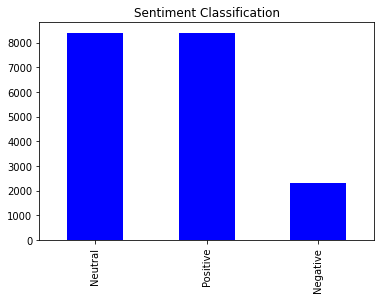

In [23]:
data.Sentiment.value_counts().plot(kind='bar', color='blue')
plt.title('Sentiment Classification')
plt.show()

In [24]:
data.head(5)

,date,tweet,Subjectivity,Polarity,Sentiment
0,2018-12-30 20:08:16,thanks tesla owners china looking forward visiting soon groundbreaking gigafactory shanghai,0.20,0.200,Positive
1,2018-12-30 19:27:46,turns take dayquil exit matrix,0.00,0.000,Neutral
2,2018-12-28 18:16:38,excited larry ellison amp kathleen wilsonthompson join tesla board,0.75,0.375,Positive
3,2018-12-28 05:53:59,ok,0.50,0.500,Positive
4,2018-12-27 21:00:00,tesla team great job,0.75,0.800,Positive


In [25]:
data = data.drop(["Subjectivity"], axis = 1)
data = data.drop(["Polarity"], axis = 1)



In [26]:
#data.to_csv("Elon tweets 2018-2021.csv")

In [28]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=" ")
tokenizer.fit_on_texts(data["tweet"].values)
X = tokenizer.texts_to_sequences(data["tweet"].values)
X = pad_sequences(X)

In [29]:
model = Sequential()
model.add(Embedding(max_fatures, 64, input_length = X.shape[1]))
model.add(LSTM(units = 32))
model.add(Dense(3, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

In [30]:
y = pd.get_dummies(data['Sentiment']).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 100)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(15276, 35) (15276, 3)
(3819, 35) (3819, 3)


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 64)            128000    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 140,515
Trainable params: 140,515
Non-trainable params: 0
_________________________________________________________________


In [32]:

history = model.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split = 0.15, verbose = 2)

Epoch 1/5
406/406 - 5s - loss: 0.5875 - acc: 0.7608 - val_loss: 0.3125 - val_acc: 0.8944 - 5s/epoch - 12ms/step
Epoch 2/5
406/406 - 3s - loss: 0.2149 - acc: 0.9348 - val_loss: 0.2120 - val_acc: 0.9372 - 3s/epoch - 7ms/step
Epoch 3/5
406/406 - 3s - loss: 0.1385 - acc: 0.9614 - val_loss: 0.2067 - val_acc: 0.9407 - 3s/epoch - 7ms/step
Epoch 4/5
406/406 - 3s - loss: 0.1077 - acc: 0.9730 - val_loss: 0.2014 - val_acc: 0.9476 - 3s/epoch - 7ms/step
Epoch 5/5
406/406 - 3s - loss: 0.0900 - acc: 0.9767 - val_loss: 0.2319 - val_acc: 0.9411 - 3s/epoch - 7ms/step


In [33]:
acc = model.evaluate(X_train, y_train)
acc

478/478 [==============================] - 1s 2ms/step - loss: 0.0944 - acc: 0.9767


[0.0943727120757103, 0.9766954779624939]

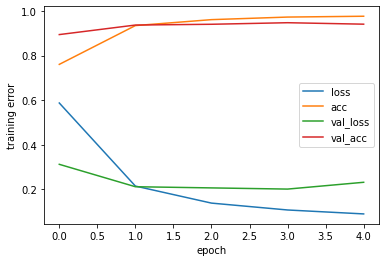

In [34]:
plt.figure("Model training")
plt.ylabel("training error")
plt.xlabel("epoch")
for i in history.history.keys():
    plt.plot(history.history[i], label = i)
plt.legend(loc = "best")

In [35]:
acc_test = model.evaluate(X_test, y_test)
acc_test

120/120 [==============================] - 0s 2ms/step - loss: 0.2242 - acc: 0.9419


[0.2242259532213211, 0.9418696165084839]

In [36]:
y_pred = model.predict(X_test) 
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
confusionM = confusion_matrix(y_test, y_pred)
print("Negative  Neutral  Positive")
print(confusionM)

Negative  Neutral  Positive
[[ 393   34   44]
 [  23 1571   54]
 [  30   37 1633]]


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       471
           1       0.96      0.95      0.96      1648
           2       0.94      0.96      0.95      1700

    accuracy                           0.94      3819
   macro avg       0.93      0.92      0.92      3819
weighted avg       0.94      0.94      0.94      3819



In [38]:
y_pred

array([0, 2, 1, ..., 2, 1, 1], dtype=int64)

In [39]:
data["date"] = data["date"].astype("datetime64")

data

,date,tweet,Sentiment
0,2018-12-30 20:08:16,thanks tesla owners china looking forward visiting soon groundbreaking gigafactory shanghai,Positive
1,2018-12-30 19:27:46,turns take dayquil exit matrix,Neutral
2,2018-12-28 18:16:38,excited larry ellison amp kathleen wilsonthompson join tesla board,Positive
3,2018-12-28 05:53:59,ok,Positive
4,2018-12-27 21:00:00,tesla team great job,Positive
...,...,...,...
3110,2021-01-02 00:00:00,tesla responsible personal amp professional pain life combined worth it,Positive
3111,2021-01-02 00:00:00,proud tesla team achieving major milestone start tesla thought optimistically chance surviving all,Positive
3112,2021-01-02 00:00:00,um giant fusion reactor sky works maintenance,Neutral
3113,2021-01-02 00:00:00,ai tesla full selfdriving work safety level well average driver year confident can’t speak regulators though,Positive


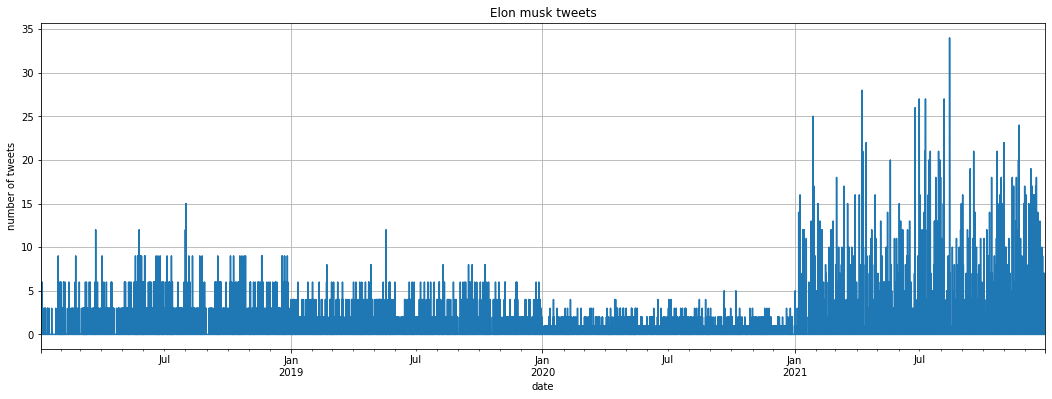

In [40]:
tweet_df = data.groupby(pd.Grouper(key="date",freq = "5 min", convention="start")).size()
tweet_df.plot(figsize=(18,6))
plt.ylabel("number of tweets")
plt.title("Elon musk tweets")
plt.grid(True)

In [41]:
tsla_data = pd.read_csv("TSLA.csv")

In [42]:
tsla_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,62.400002,64.421997,62.200001,64.106003,64.106003,21761000
1,2018-01-03,64.199997,65.050003,63.110001,63.450001,63.450001,22607500
2,2018-01-04,62.574001,63.709999,61.136002,62.924000,62.924000,49731500
3,2018-01-05,63.324001,63.448002,62.400002,63.316002,63.316002,22956000
4,2018-01-08,63.200001,67.403999,63.099998,67.281998,67.281998,49297000
...,...,...,...,...,...,...,...
1002,2021-12-23,1006.799988,1072.979980,997.559998,1067.000000,1067.000000,30904400
1003,2021-12-27,1073.670044,1117.000000,1070.719971,1093.939941,1093.939941,23715300
1004,2021-12-28,1109.489990,1119.000000,1078.420044,1088.469971,1088.469971,20108000
1005,2021-12-29,1098.640015,1104.000000,1064.140015,1086.189941,1086.189941,18718000


In [43]:
tsla_data = tsla_data[["Date", "Close"]]

In [44]:
#tsla_data["Date"] = tsla_data["Date"].astype("datetime64")
 
# Setting the Date as index

tsla_data = tsla_data.set_index("Date")
tsla_data

,Close
Date,
2018-01-02,64.106003
2018-01-03,63.450001
2018-01-04,62.924000
2018-01-05,63.316002
2018-01-08,67.281998
...,...
2021-12-23,1067.000000
2021-12-27,1093.939941
2021-12-28,1088.469971


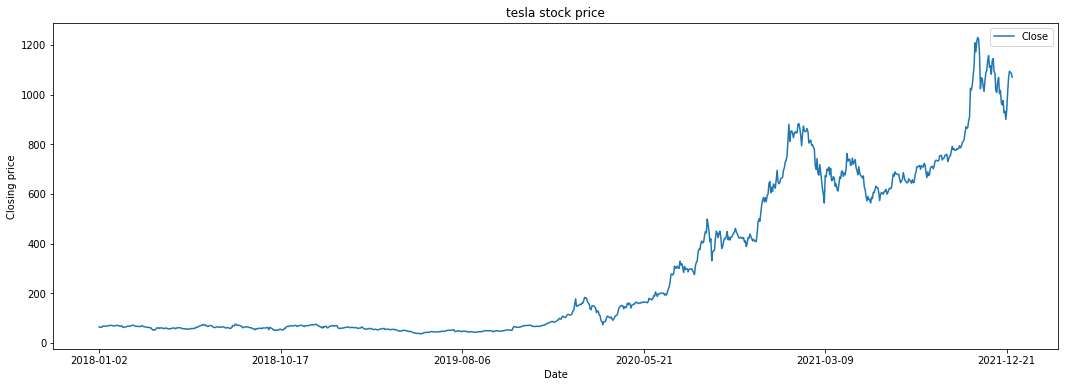

In [45]:
tsla_data.plot(figsize=(18,6))

plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("Tesla stock price")

# Display

plt.show()